In [1]:
from __future__ import division
import os
import cv2
import numpy as np
import sys
import pickle
from optparse import OptionParser
import time
from keras_frcnn import config
from keras import backend as K
from keras.layers import Input
from keras.models import Model
from keras_frcnn import roi_helpers
import matplotlib
matplotlib.use('Agg')

sys.setrecursionlimit(40000)

Using TensorFlow backend.


In [2]:
'''
parser = OptionParser()

parser.add_option("-p", "--path", dest="test_path", help="Path to test data.")
parser.add_option("-n", "--num_rois", dest="num_rois",
				help="Number of ROIs per iteration. Higher means more memory use.", default=32)
parser.add_option("--config_filename", dest="config_filename", help=
				"Location to read the metadata related to the training (generated when training).",
				default="config.pickle")
parser.add_option("--network", dest="network", help="Base network to use. Supports vgg or resnet50.", default='resnet50')

(options, args) = parser.parse_args()

if not options.test_path:   # if filename is not given
	parser.error('Error: path to test data must be specified. Pass --path to command line')

'''
config_output_filename = 'config.pickle' #options.config_filename

with open(config_output_filename, 'rb') as f_in:
	C = pickle.load(f_in)

#if C.network == 'resnet50':
import keras_frcnn.resnet as nn
#elif C.network == 'vgg':
#	import keras_frcnn.vgg as nn

# turn off any data augmentation at test time
C.use_horizontal_flips = False
C.use_vertical_flips = False
C.rot_90 = False

num_rois = 32
img_path = 'in_images' #options.test_path

print('This notebook equals below command line:')
print('python test_frcnn.py -p {}'.format(img_path))

This notebook equals below command line:
python test_frcnn.py -p in_images


In [3]:
def format_img_size(img, C):
	""" formats the image size based on config """
	img_min_side = float(C.im_size)
	(height,width,_) = img.shape
		
	if width <= height:
		ratio = img_min_side/width
		new_height = int(ratio * height)
		new_width = int(img_min_side)
	else:
		ratio = img_min_side/height
		new_width = int(ratio * width)
		new_height = int(img_min_side)
	img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
	return img, ratio	

def format_img_channels(img, C):
	""" formats the image channels based on config """
	img = img[:, :, (2, 1, 0)]
	img = img.astype(np.float32)
	img[:, :, 0] -= C.img_channel_mean[0]
	img[:, :, 1] -= C.img_channel_mean[1]
	img[:, :, 2] -= C.img_channel_mean[2]
	img /= C.img_scaling_factor
	img = np.transpose(img, (2, 0, 1))
	img = np.expand_dims(img, axis=0)
	return img

def format_img(img, C):
	""" formats an image for model prediction based on config """
	img, ratio = format_img_size(img, C)
	img = format_img_channels(img, C)
	return img, ratio

# Method to transform the coordinates of the bounding box to its original size
def get_real_coordinates(ratio, x1, y1, x2, y2):

	real_x1 = int(round(x1 // ratio))
	real_y1 = int(round(y1 // ratio))
	real_x2 = int(round(x2 // ratio))
	real_y2 = int(round(y2 // ratio))

	return (real_x1, real_y1, real_x2 ,real_y2)



In [4]:
class_mapping = C.class_mapping

if 'bg' not in class_mapping:
	class_mapping['bg'] = len(class_mapping)

class_mapping = {v: k for k, v in class_mapping.items()}
print(class_mapping)
class_to_color = {class_mapping[v]: np.random.randint(0, 255, 3) for v in class_mapping}
C.num_rois = num_rois #int(options.num_rois)

#if C.network == 'resnet50':
num_features = 1024
#elif C.network == 'vgg':
#	num_features = 512

if K.image_dim_ordering() == 'th':
	input_shape_img = (3, None, None)
	input_shape_features = (num_features, None, None)
else:
	input_shape_img = (None, None, 3)
	input_shape_features = (None, None, num_features)


img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(C.num_rois, 4))
feature_map_input = Input(shape=input_shape_features)

# define the base network (resnet here, can be VGG, Inception, etc)
shared_layers = nn.nn_base(img_input, trainable=True)

# define the RPN, built on the base layers
num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios)
rpn_layers = nn.rpn(shared_layers, num_anchors)

classifier = nn.classifier(feature_map_input, roi_input, C.num_rois, nb_classes=len(class_mapping), trainable=True)

model_rpn = Model(img_input, rpn_layers)
model_classifier_only = Model([feature_map_input, roi_input], classifier)

model_classifier = Model([feature_map_input, roi_input], classifier)

print('Loading weights from {}'.format(C.model_path))
model_rpn.load_weights(C.model_path, by_name=True)
model_classifier.load_weights(C.model_path, by_name=True)

model_rpn.compile(optimizer='sgd', loss='mse')
model_classifier.compile(optimizer='sgd', loss='mse')

all_imgs = []

classes = {}

bbox_threshold = 0.8

visualise = True

for idx, img_name in enumerate(sorted(os.listdir(img_path))):
	if not img_name.lower().endswith(('.bmp', '.jpeg', '.jpg', '.png', '.tif', '.tiff')):
		continue
	print(img_name)
	st = time.time()
	filepath = os.path.join(img_path,img_name)

	img = cv2.imread(filepath)

	X, ratio = format_img(img, C)

	if K.image_dim_ordering() == 'tf':
		X = np.transpose(X, (0, 2, 3, 1))

	# get the feature maps and output from the RPN
	[Y1, Y2, F] = model_rpn.predict(X)
	

	R = roi_helpers.rpn_to_roi(Y1, Y2, C, K.image_dim_ordering(), overlap_thresh=0.7)

	# convert from (x1,y1,x2,y2) to (x,y,w,h)
	R[:, 2] -= R[:, 0]
	R[:, 3] -= R[:, 1]

	# apply the spatial pyramid pooling to the proposed regions
	bboxes = {}
	probs = {}

	for jk in range(R.shape[0]//C.num_rois + 1):
		ROIs = np.expand_dims(R[C.num_rois*jk:C.num_rois*(jk+1), :], axis=0)
		if ROIs.shape[1] == 0:
			break

		if jk == R.shape[0]//C.num_rois:
			#pad R
			curr_shape = ROIs.shape
			target_shape = (curr_shape[0],C.num_rois,curr_shape[2])
			ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
			ROIs_padded[:, :curr_shape[1], :] = ROIs
			ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
			ROIs = ROIs_padded

		[P_cls, P_regr] = model_classifier_only.predict([F, ROIs])

		for ii in range(P_cls.shape[1]):

			if np.max(P_cls[0, ii, :]) < bbox_threshold or np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
				continue

			cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]

			if cls_name not in bboxes:
				bboxes[cls_name] = []
				probs[cls_name] = []

			(x, y, w, h) = ROIs[0, ii, :]

			cls_num = np.argmax(P_cls[0, ii, :])
			try:
				(tx, ty, tw, th) = P_regr[0, ii, 4*cls_num:4*(cls_num+1)]
				tx /= C.classifier_regr_std[0]
				ty /= C.classifier_regr_std[1]
				tw /= C.classifier_regr_std[2]
				th /= C.classifier_regr_std[3]
				x, y, w, h = roi_helpers.apply_regr(x, y, w, h, tx, ty, tw, th)
			except:
				pass
			bboxes[cls_name].append([C.rpn_stride*x, C.rpn_stride*y, C.rpn_stride*(x+w), C.rpn_stride*(y+h)])
			probs[cls_name].append(np.max(P_cls[0, ii, :]))

	all_dets = []

	for key in bboxes:
		bbox = np.array(bboxes[key])

		new_boxes, new_probs = roi_helpers.non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=0.5)
		for jk in range(new_boxes.shape[0]):
			(x1, y1, x2, y2) = new_boxes[jk,:]

			(real_x1, real_y1, real_x2, real_y2) = get_real_coordinates(ratio, x1, y1, x2, y2)

			cv2.rectangle(img,(real_x1, real_y1), (real_x2, real_y2), (int(class_to_color[key][0]), int(class_to_color[key][1]), int(class_to_color[key][2])),2)

			textLabel = '{}: {}'.format(key,int(100*new_probs[jk]))
			all_dets.append((key,100*new_probs[jk]))

			(retval,baseLine) = cv2.getTextSize(textLabel,cv2.FONT_HERSHEY_COMPLEX,1,1)
			textOrg = (real_x1, real_y1-0)

			cv2.rectangle(img, (textOrg[0] - 5, textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (0, 0, 0), 2)
			cv2.rectangle(img, (textOrg[0] - 5,textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (255, 255, 255), -1)
			cv2.putText(img, textLabel, textOrg, cv2.FONT_HERSHEY_DUPLEX, 1, (0, 0, 0), 1)

	print('Elapsed time = {}'.format(time.time() - st))
	print(all_dets)
	#cv2.imshow('img', img)
	#cv2.waitKey(0)
	cv2.imwrite('./results_imgs/{}.png'.format(idx),img)

print('---All Done---')

{0: 'dog', 1: 'car', 2: 'pottedplant', 3: 'bird', 4: 'train', 5: 'sheep', 6: 'person', 7: 'tvmonitor', 8: 'bottle', 9: 'chair', 10: 'cat', 11: 'bus', 12: 'cow', 13: 'diningtable', 14: 'sofa', 15: 'horse', 16: 'motorbike', 17: 'bicycle', 18: 'boat', 19: 'aeroplane', 20: 'bg'}
Loading weights from ./model_frcnn.hdf5
10465.jpg
Elapsed time = 16.606089115142822
[('person', 96.318608522415161)]
---All Done---


In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline

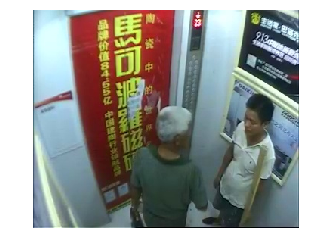

In [6]:

img=mpimg.imread('./in_images/10465.jpg')
plt.axis('off')
imgplot = plt.imshow(img)

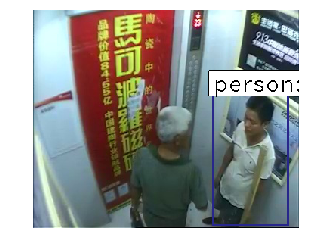

In [7]:
img_out=mpimg.imread('./results_imgs/0.png')
plt.axis('off')
imgplot = plt.imshow(img_out)

# Process the .h264 file

In [12]:
'''
run the command line of ffmpeg
ffmpeg -i 1.264 -r 1/1 ../264_imgs/$filename%03d.jpg
'''
